# Tarefa 6 - Árvore de decisão e KNN com Regressão

####**Dicas:**

- Tutorial para iniciantes em Python: https://www.datacamp.com/cheat-sheet/getting-started-with-python-cheat-sheet

- Documentação do pandas: https://colab.research.google.com/drive/1a4sbKG7jOJGn4oeonQPA8XjJm7OYgcdX

- Documentação do scikit-learn: https://scikit-learn.org/stable/

- Documentação do matplotlib: https://matplotlib.org/stable/index.html

- Documentação do seaborn: https://seaborn.pydata.org/tutorial.html

---
## **Sobre o dataset:**

Este dataset contém informações sobre o uso de bicicletas de aluguel em cidades urbanas, incluindo dados meteorológicos, como temperatura, umidade, velocidade do vento, visibilidade, ponto de orvalho, radiação solar, queda de neve e precipitação. Ele permite prever a quantidade de bicicletas necessárias a cada hora, facilitando a disponibilidade e acessibilidade para os usuários.

**Colunas:**

- **Rented Bike Count** - Contagem de bicicletas alugadas a cada hora **(target)**

- **Hour** - Hora do dia
- **Temperature** - Temperatura em Celsius
- **Humidity** - %
- **Windspeed** - m/s
- **Visibility** - 10m
- **Dew point temperature** - Temperatura do ponto de orvalho em Celsius
- **Solar radiation** - MJ/m²
- **Rainfall** - mm
- **Snowfall** - cm
- **Seasons** - Inverno, Primavera, Verão, Outono
- **Holiday** - Feriado/Sem feriado




## **Importe os pacotes**

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

## **Crie os datasets**
### **Crie um DataFrame a partir do arquivo de dados disponibilizados no EaD**

**Dicas:**

* Certifique-se que os arquivos a serem lidos estão carregados na sua sessão do Colab, ou em um drive previamente montado, e ajuste o comando para incluir todo o caminho até cada um dos arquivos a serem lidos.

In [315]:
path = 'SeoulBikeData.csv'
df = pd.read_csv(path)
df.head()

,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday


In [316]:
df.describe()

,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [317]:
print(df.Seasons.unique())
print(df.Holiday.unique())

['Winter' 'Spring' 'Summer' 'Autumn']
['No Holiday' 'Holiday']


In [318]:
df.isna().sum()

,0
Rented Bike Count,0
Hour,0
Temperature,0
Humidity(%),0
Wind speed (m/s),0
Visibility (10m),0
Dew point temperature,0
Solar Radiation (MJ/m2),0
Rainfall(mm),0
Snowfall (cm),0


## **Pré-Processamento dos Dados**

Aplique as técnicas de pré-processamento que vimos em aula no dataset fornecido.

### **Dicas:**
- **Converter dados categóricos para numéricos:** Use `LabelEncoder` ou `OneHotEncoder`.

- **Transformar os dados:** Experimente `MinMaxScaler` para ajustar a escala dos dados.

- **Remover outliers:** Verifique outliers com base no IQR e os elimine se necessário.

- **Tratar valores nulos:** Preencha com a média, moda, mediana ou remova as linhas, dependendo do impacto no dataset.


In [319]:
le_holiday = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
scaler = MinMaxScaler()

def pre_processing(df: pd.DataFrame, remove_outliers: bool, first_time=True):
    if first_time:
        df['Holiday'] = le_holiday.fit_transform(df['Holiday'])
        seasons = ohe.fit_transform(df[['Seasons']])
        df = pd.concat([df, seasons], axis=1)
        df.drop(columns=['Seasons'], axis = 1, inplace = True)
        df[df.columns] = scaler.fit_transform(df[df.columns])
    else:
        df['Holiday'] = le_holiday.transform(df['Holiday'])
        seasons = ohe.transform(df[['Seasons']])
        df = pd.concat([df, seasons], axis=1)
        df.drop(columns=['Seasons'], axis = 1, inplace = True)
        df[df.columns] = scaler.transform(df[df.columns])

    if remove_outliers:
        # as outras colunas ou não possuem outliers ou zeram o DataFrame
        for col in ['Rented Bike Count', 'Wind speed (m/s)', 'Solar Radiation (MJ/m2)']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    # df não possui valores nulos
    return df

df = pre_processing(df=df, remove_outliers=True)

print(df.columns)
print(df.shape)
df.head()

Index(['Rented Bike Count', 'Hour', 'Temperature', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Holiday',
       'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter'],
      dtype='object')
(7760, 15)


,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,0.071429,0.000000,0.220280,0.377551,0.297297,1.0,0.224913,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.057368,0.043478,0.215035,0.387755,0.108108,1.0,0.224913,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.048650,0.086957,0.206294,0.397959,0.135135,1.0,0.223183,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.030090,0.130435,0.202797,0.408163,0.121622,1.0,0.224913,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.021935,0.173913,0.206294,0.367347,0.310811,1.0,0.207612,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# **Criação de Conjuntos de Treinamento, Teste e Validação**

Divida os dados em conjuntos de treino, validação e teste. Para isso, selecione aleatoriamente 70% dos registros, sem reposição, para o conjunto de treinamento. Os 30% restantes deverão ser divididos igualmente entre os conjuntos de validação e teste.

Dicas:
- Fixe a semente de geração de dados aleatórios, utilize o comando `np.random.seed(escolha um número)`, antes de executar qualquer célula de comando que possa variar de valor resultante toda vez que for executada.

- Para fazer a divisão de treino, validação, teste use a função `train_test_split()`

In [320]:
np.random.seed(42)
X = df.drop('Rented Bike Count', axis=1)
y = df['Rented Bike Count']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.70)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# **Treine e Teste o Modelo de Árvore de Decisão**

Treinar três versões diferentes do modelo de Árvore de Decisão utilizando valores variados para a sua profundidade.

**Dica:**

- Busque pela função `DecisionTreeRegressor(max_depth=?)` da biblioteca scikitlearn

In [321]:
depths = [3, 6, 9]
trees = []

for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=10)
    regressor.fit(X_train, y_train)
    y_val_pred = regressor.predict(X_val)

    trees.append({
        'model': regressor,
        'depth': depth,
        'pred': y_val_pred
    })

# **Avaliação do Modelo**

Neste momento, é importante avaliar cada um dos modelos gerados utilizando o **dataset de validação**. Apresente as métricas de erro quadrático médio (MSE), erro absoluto médio (MAE), e coeficiente de determinação (R²) para cada modelo.

**Dica:**

- Você pode usar a função `mean_squared_error(_, _)` da biblioteca `scikitlearn.metrics` e, para calcular as demais métricas do modelo, busque pelas funções `mean_absolute_error()` e `r2_score()`.

In [322]:
for tree in trees:
    tree['MSE'] = mean_squared_error(y_val, tree['pred'])
    tree['MAE'] = mean_absolute_error(y_val, tree['pred'])
    tree['R2'] = r2_score(y_val, tree['pred'])

    print(f'Tree of depth {tree["depth"]}:')
    print(f'• MSE: {tree["MSE"]}')
    print(f'• MAE: {tree["MAE"]}')
    print(f'• R2: {tree["R2"]}\n')


Tree of depth 3:
• MSE: 0.01125636311143318
• MAE: 0.07355596136822562
• R2: 0.5728412399918636

Tree of depth 6:
• MSE: 0.009124968779034728
• MAE: 0.06250552484336229
• R2: 0.6537238262324361

Tree of depth 9:
• MSE: 0.009210326036373298
• MAE: 0.05786057333169195
• R2: 0.6504846716456935



# **Feature Importance**

Gere o gráfico de importância das features para o modelo que obteve o melhor desempenho nos dados de validação. Em seguida, remova as **cinco** features com menor importância e treine o modelo novamente.

**Dica**

- Utilize o método `.feature_importances_` da biblioteca `sklearn` para obter os valores de importância de cada feature.



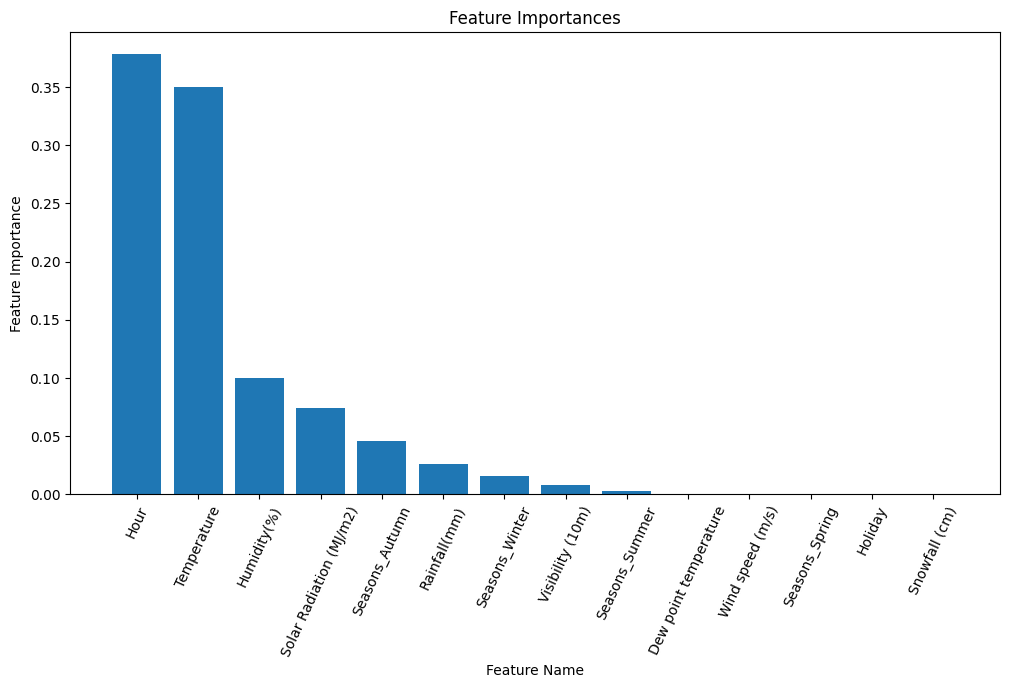

In [323]:
best_model = trees[1]['model']

plt.figure(figsize=(12, 6))
importances = best_model.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]

sorted_importances = importances[indices]
sorted_features = features[indices]

plt.bar(sorted_features, sorted_importances)

plt.xticks(rotation=65)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [324]:
least_important_features = ['Dew point temperature', 'Seasons_Summer', 'Snowfall (cm)', 'Seasons_Winter', 'Holiday']

X_train.drop(columns=least_important_features, inplace=True)
X_val.drop(columns=least_important_features, inplace=True)
X_test.drop(columns=least_important_features, inplace=True)

# **Avaliação do Novo Modelo**

Com as cinco features removidas, treine novamente o modelo de árvore de decisão escolhido, e o avalie novamente utilizando apenas o **conjunto de validação**.

In [325]:
depth = 6
regressor = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=10)

regressor.fit(X_train, y_train)
y_val_pred = regressor.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'• MSE: {mse}')
print(f'• MAE: {mae}')
print(f'• R2: {r2}')

• MSE: 0.00912895814929383
• MAE: 0.06247477758212654
• R2: 0.653572436797303


# **Plotar a árvore do melhor modelo**

Gere a visualização da Árvore de Decisão do novo modelo

**Dica:**

- Use a função `plot_tree()` da biblioteca `sklearn`

- Para tornar a visualização mais clara e facilitar a interpretação dos resultados, ajuste o parâmetro max_depth em `plot_tree(max_depth=?)`, limitando a profundidade da árvore exibida e destacando os nós mais significativos.

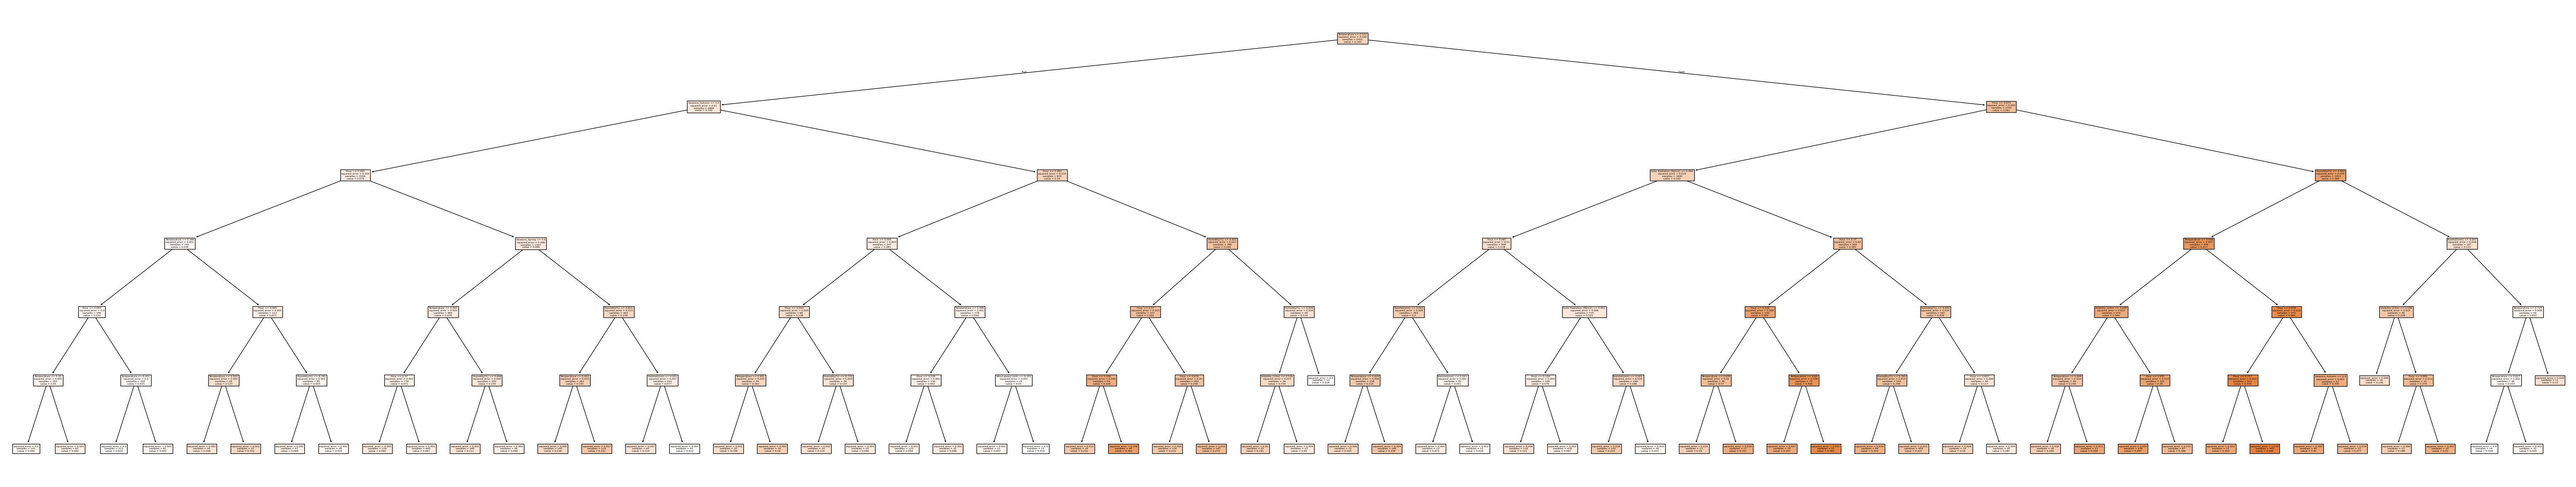

In [326]:
plt.figure(figsize=(80, 15))
plot_tree(regressor, filled=True, feature_names=regressor.feature_names_in_)

plt.savefig('decision_tree_regressor_full.svg', format='svg')

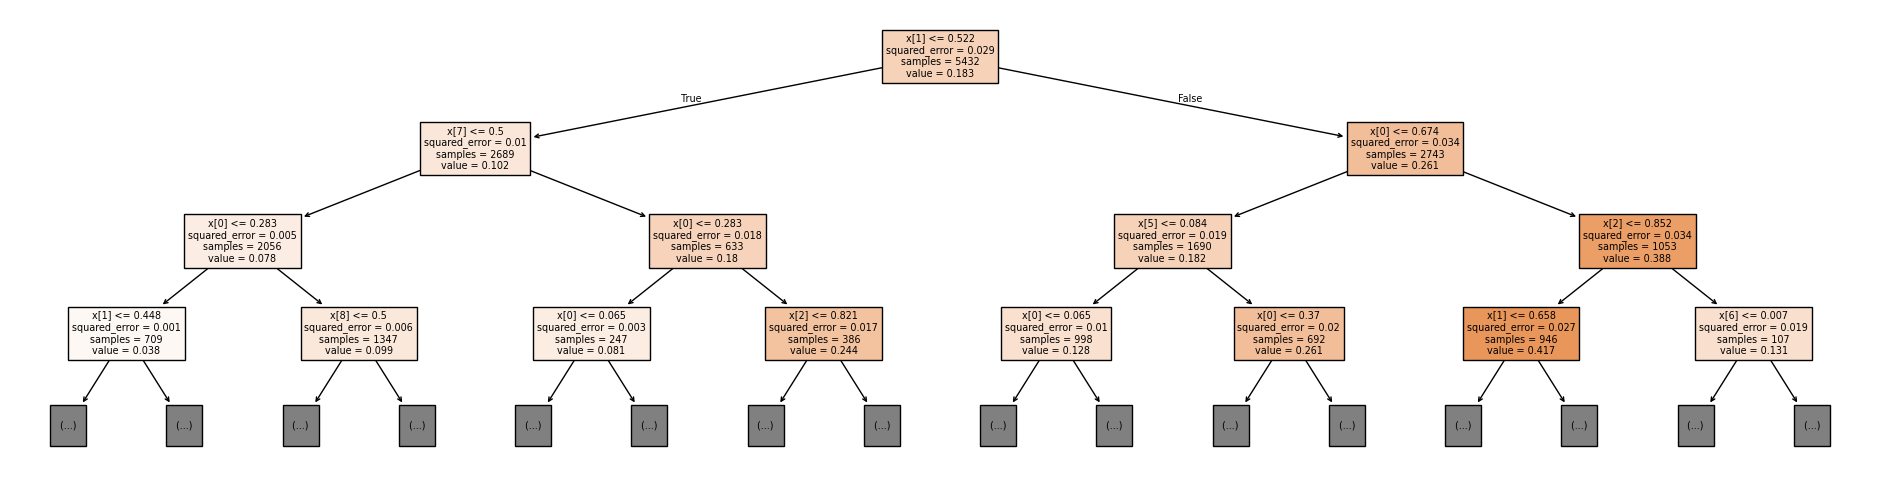

In [327]:
plt.figure(figsize=(24, 6))
plot_tree(regressor, max_depth=3, filled=True)

plt.savefig('decision_tree_regressor.svg', format='svg')

# **Criação de Exemplos Fictícios**

Observe a estrutura da árvore de decisão treinada e crie dois exemplos fictícios com valores de entrada diferentes. Para cada exemplo, descreva detalhadamente o caminho que ele seguirá na árvore, ou seja, a sequência de nós que serão percorridos até chegar à folha correspondente.

In [328]:
example_df = pd.DataFrame(data={
    'Rented Bike Count': [112, 1753], # Valores não representativos do conjunto de dados
    'Hour': [0, 20],
    'Temperature': [-7.2, 18.8],
    'Humidity(%)': [37, 40],
    'Wind speed (m/s)': [2.2, 0.9],
    'Visibility (10m)': [2000, 2000],
    'Dew point temperature': [-17.6, 5.7],
    'Solar Radiation (MJ/m2)': [0.0, 0.0],
    'Rainfall(mm)': [0.0, 0.0],
    'Snowfall (cm)': [0.0, 0.0],
    'Seasons': ['Spring', 'Autumn'],
    'Holiday': ['No Holiday', 'Holiday']
})

In [329]:
example_df = pre_processing(df=example_df, remove_outliers=False, first_time=False)
example_df['Seasons_Summer'] = [0.0, 0.0] # Seasons_Summer e Seasons_Winter não são criados automaticamente pelo OneHotEncoder
example_df['Seasons_Winter'] = [0.0, 0.0]
example_df.drop(least_important_features, axis=1, inplace=True)
example_df.head()

# TODO: consertar discrepância entre análise da árvore e valores preditos

,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Seasons_Autumn,Seasons_Spring
0,0.031496,0.000000,0.185315,0.377551,0.297297,1.0,0.0,0.0,0.0,1.0
1,0.492970,0.869565,0.639860,0.408163,0.121622,1.0,0.0,0.0,1.0,0.0


# **Inferência e Verificação**

Realize uma inferência utilizando esses dois exemplos fictícios no modelo treinado. Verifique se os resultados obtidos na inferência correspondem aos valores do target que você imaginou ao criar os exemplos.

In [330]:
regressor.predict(example_df.drop('Rented Bike Count', axis=1))

array([0.04215438, 0.38693745])

# **Treine e Teste o Modelo de KNN**

Treinar três versões diferentes do modelo K-Nearest Neighbors (KNN) utilizando valores variados para o parâmetro K.

**Dica:**
- Busque pela função `KNeighborsRegressor(n_neighbors=?)` da biblioteca `scikitlearn`

In [331]:
k_values = [3, 5, 7]
knn_models = []

for k in k_values:
    regressor = KNeighborsRegressor(n_neighbors=k)
    regressor.fit(X_train, y_train)
    y_val_pred = regressor.predict(X_val)

    knn_models.append({
        'model': regressor,
        'k': k,
        'pred': y_val_pred
    })

# **Avaliação do Modelo**

Neste momento, é importante avaliar cada um dos modelos gerados utilizando o **dataset de validação**. Apresente as métricas de erro quadrático médio (MSE), erro absoluto médio (MAE), e coeficiente de determinação (R²) para cada modelo.

**Dica:**

- Você pode usar a função `mean_squared_error()` da biblioteca `scikitlearn.metrics` e, para calcular as demais métricas do modelo, busque pelas funções `mean_absolute_error()` e `r2_score()`.

In [332]:
for knn in knn_models:
    knn['MSE'] = mean_squared_error(y_val, knn['pred'])
    knn['MAE'] = mean_absolute_error(y_val, knn['pred'])
    knn['R2'] = r2_score(y_val, knn['pred'])

    print(f'KNN with {knn["k"]} neighbors:')
    print(f'• MSE: {knn["MSE"]}')
    print(f'• MAE: {knn["MAE"]}')
    print(f'• R2: {knn["R2"]}\n')

KNN with 3 neighbors:
• MSE: 0.008971108154489652
• MAE: 0.0588907539908027
• R2: 0.65956256055045

KNN with 5 neighbors:
• MSE: 0.008625596614227104
• MAE: 0.05917214600752226
• R2: 0.6726741028528784

KNN with 7 neighbors:
• MSE: 0.008407113602408606
• MAE: 0.059706143598765915
• R2: 0.6809651406851993



# **Escolha do melhor modelo**

Selecione o melhor modelo até agora com base no desempenho no conjunto de validação (KNN ou a Árvore de Decisão; a avaliação determinará a escolha) e avalie-o no **conjunto de** **teste**.

In [333]:
best_tree = trees[1]
print(f'Best tree (depth {best_tree["depth"]}):')
print(f'• MSE: {best_tree["MSE"]}')
print(f'• MAE: {best_tree["MAE"]}')
print(f'• R2: {best_tree["R2"]}\n')

best_knn = knn_models[2]
print(f'Best KNN ({best_knn["k"]} neighbors):')
print(f'• MSE: {best_knn["MSE"]}')
print(f'• MAE: {best_knn["MAE"]}')
print(f'• R2: {best_knn["R2"]}\n')

print(f'The best model is the KNN with K = {best_knn["k"]}\n')

Best tree (depth 6):
• MSE: 0.009124968779034728
• MAE: 0.06250552484336229
• R2: 0.6537238262324361

Best KNN (7 neighbors):
• MSE: 0.008407113602408606
• MAE: 0.059706143598765915
• R2: 0.6809651406851993

The best model is the KNN with K = 7



In [334]:
y_test_pred = regressor.predict(X_test)

# **Mostre uma análise comparativa entre validação e teste para o modelo escolhido**

**Observação:** Se houver uma discrepância muito grande nos resultados, algo pode estar errado, verifique seu treinamento e avaliação do modelo.

In [335]:
print('Validation set predictions:')
print(f'• MSE: {best_knn["MSE"]}')
print(f'• MAE: {best_knn["MAE"]}')
print(f'• R2: {best_knn["R2"]}\n')

print('Test set predictions:')
print(f'• MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'• MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'• R2: {r2_score(y_test, y_test_pred)}\n')

Validation set predictions:
• MSE: 0.008407113602408606
• MAE: 0.059706143598765915
• R2: 0.6809651406851993

Test set predictions:
• MSE: 0.008653552403583438
• MAE: 0.05884869371078247
• R2: 0.6857605890560758

